In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

import sklearn
from sklearn.externals import joblib

import neuravi

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Loading dataset

Dataset has been prepared before`

In [2]:
d = neuravi.Data("./data/")

## model with TensorFlow and MYEGA equation (expressed as a function of Tg and fragility m)

The MYEGA viscosity equation is:


$$log(\eta_{T}) = log(\eta_{\infty}) + (12-log(\eta_{\infty}))\frac{T_g}{T} exp((\frac{m}{12-log(\eta_{\infty})}-1)(\frac{Tg}{T} - 1))$$

In [3]:
# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = d.X_train[:,0:14]
temperature_train = d.X_train[:,14].reshape(-1,1)

chimie_valid = d.X_valid[:,0:14]
temperature_valid = d.X_valid[:,14].reshape(-1,1)

chimie_test = d.X_test[:,0:14]
temperature_test = d.X_test[:,14].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

We then create an object to create a network with 1 to 5 layers (ReLu activation units + dropout),

Following the reading of Kaufl, we will initiate the bias of the output neural net layer to values of parameters that are not far from reality.

Then results of output layer are used to calculate the parameters of the A-G equation (see above), which, in turn, gives the viscosity.

We use a L2 loss to determine distance from targets.

Optimizer is RMSprop, it seems the most stable from my test.

The code for the object is in the file neuravi.py

In [40]:
NIN = chimie_train.shape[1]
NHIDDEN = 100
NLAYER = 1
STDEV = 0.0001
bias = np.array([-4.5,np.log(500.),np.log(10.)])

mod = neuravi.Model_MYEGA(NIN, num_layers=NLAYER,hidden_size=NHIDDEN, init_bias = bias)

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

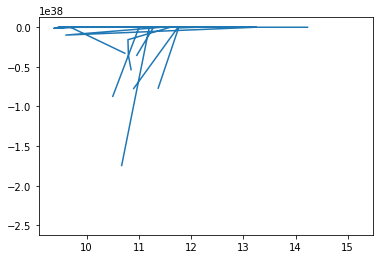

In [41]:
try:
    sess.close()
except:
    print("OK, no interactive session running")

sess = tf.InteractiveSession()
sess.run(mod.init_op)

pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train, 
                                             mod.input_T: temperature_train, 
                                             mod.input_y: d.y_train.reshape(-1,1)})
plt.figure()
plt.plot(d.y_train, pred_ini)

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [23]:
NEPOCH = 10000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, mod.input_T: temperature_train, mod.input_y: d.y_train.reshape(-1,1)}
    dct_valid = {mod.input_c: chimie_valid, mod.input_T: temperature_valid, mod.input_y: d.y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]:
        count_es += 1
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 284233.4375, 1151453952.0
Batch train and valid loss at step 500: 266591.9375, 54718.390625
Batch train and valid loss at step 1000: 226439.40625, 46611.9921875
Batch train and valid loss at step 1500: 171273.96875, 35431.48828125
Batch train and valid loss at step 2000: 112621.1796875, 23406.759765625
Batch train and valid loss at step 2500: 65724.890625, 13528.5263671875
Batch train and valid loss at step 3000: 47939.546875, 9278.69140625
Batch train and valid loss at step 3500: 46647.3671875, 9068.5712890625
Batch train and valid loss at step 4000: 45385.2265625, 8845.908203125
Batch train and valid loss at step 4500: 44095.8671875, 8703.3369140625
Batch train and valid loss at step 5000: 42906.4375, 8522.59375
Batch train and valid loss at step 5500: 41984.65234375, 8378.212890625
Batch train and valid loss at step 6000: 41371.42578125, 8194.78515625
Batch train and valid loss at step 6500: 40914.734375, 8009.9013671875
Batch train and valid lo

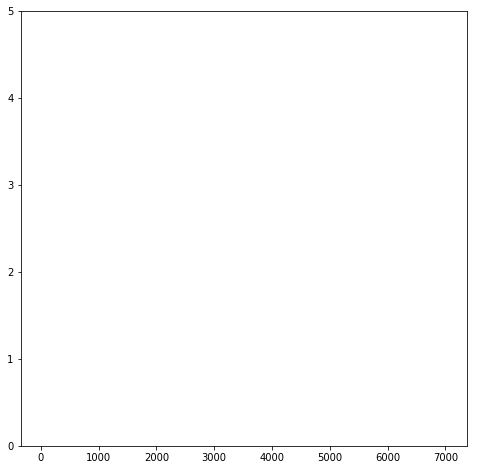

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, NEPOCH,1), loss_train/d.X_train.shape[0], 'r-')
plt.plot(np.arange(0, NEPOCH,1), loss_valid/d.X_valid.shape[0], 'b-')
plt.ylim(0,5)
plt.show()
plt.savefig("epochs_cg.pdf")

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [8]:
name_out = "MYEGA_layer_"+str(NLAYER)+"units_"+str(NHIDDEN)+"it_"+str(NEPOCH)

tf.saved_model.simple_save(sess,
            "./model/"+name_out,
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/layer1units100it200000/saved_model.pb


(-3, 15)

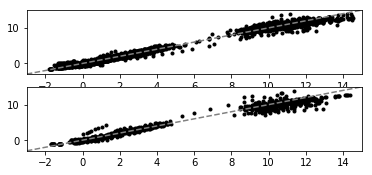

In [30]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(d.y_train, sess.run(mod.visco_pred,feed_dict=dct_train),"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.subplot(3,1,2)
plt.plot(d.y_valid, sess.run(mod.visco_pred,feed_dict=dct_valid),"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)